In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D, Multiply, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Load dataset
training_set = tf.keras.utils.image_dataset_from_directory(
    'train', labels="inferred", label_mode="categorical", batch_size=32, image_size=(128, 128), shuffle=True)

validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid', labels="inferred", label_mode="categorical", batch_size=32, image_size=(128, 128), shuffle=True)


Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [3]:
# Attention Mechanism: Squeeze-and-Excitation Block
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

In [4]:
# Build Hybrid CNN Model with Attention
inputs = layers.Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = se_block(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = se_block(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = se_block(x)
x = MaxPool2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = se_block(x)
x = MaxPool2D((2, 2))(x)

x = Flatten()(x)
x = Dense(1500, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(38, activation='softmax')(x)

model = Model(inputs, outputs)

In [5]:
# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
# Train Model
training_history = model.fit(x=training_set, validation_data=validation_set, epochs=10)


Epoch 1/10
2197/2197 [==============================] - 335s 140ms/step - loss: 1.0121 - accuracy: 0.7000 - val_loss: 0.3406 - val_accuracy: 0.8915
Epoch 2/10
2197/2197 [==============================] - 304s 138ms/step - loss: 0.2708 - accuracy: 0.9121 - val_loss: 0.2435 - val_accuracy: 0.9190
Epoch 3/10
2197/2197 [==============================] - 304s 138ms/step - loss: 0.1468 - accuracy: 0.9511 - val_loss: 0.1855 - val_accuracy: 0.9403
Epoch 4/10
2197/2197 [==============================] - 338s 154ms/step - loss: 0.0983 - accuracy: 0.9664 - val_loss: 0.1521 - val_accuracy: 0.9524
Epoch 5/10
2197/2197 [==============================] - 550s 250ms/step - loss: 0.0728 - accuracy: 0.9757 - val_loss: 0.1757 - val_accuracy: 0.9478
Epoch 6/10
2197/2197 [==============================] - 228s 104ms/step - loss: 0.0561 - accuracy: 0.9810 - val_loss: 0.1529 - val_accuracy: 0.9558
Epoch 7/10
2197/2197 [==============================] - 226s 103ms/step - loss: 0.0476 - accuracy: 0.9842 - val_

In [7]:
# Save Model
model.save("hybrid_cnn_with_attention.keras")

In [8]:
# Model Evaluation
train_loss, train_acc = model.evaluate(training_set)
val_loss, val_acc = model.evaluate(validation_set)
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


550/550 [==============================] - 17s 30ms/step - loss: 0.2453 - accuracy: 0.9344
Train Loss: 0.04364357516169548, Train Accuracy: 0.9848068952560425
Validation Loss: 0.24530920386314392, Validation Accuracy: 0.9343842267990112


In [9]:
# Prediction on Test Set
test_set = tf.keras.utils.image_dataset_from_directory(
    'valid', labels="inferred", label_mode="categorical", batch_size=32, image_size=(128, 128), shuffle=False)

y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)


Found 17572 files belonging to 38 classes.
550/550 [==============================] - 16s 29ms/step


In [10]:
# Classification Report
class_names = validation_set.class_names
print(classification_report(Y_true, predicted_categories, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.88      0.90      0.89       504
                                 Apple___Black_rot       0.97      0.98      0.98       497
                          Apple___Cedar_apple_rust       0.98      0.90      0.94       440
                                   Apple___healthy       0.82      0.97      0.88       502
                               Blueberry___healthy       0.92      0.98      0.95       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       421
                 Cherry_(including_sour)___healthy       0.99      0.97      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.85      0.89       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.90      0.96      0.

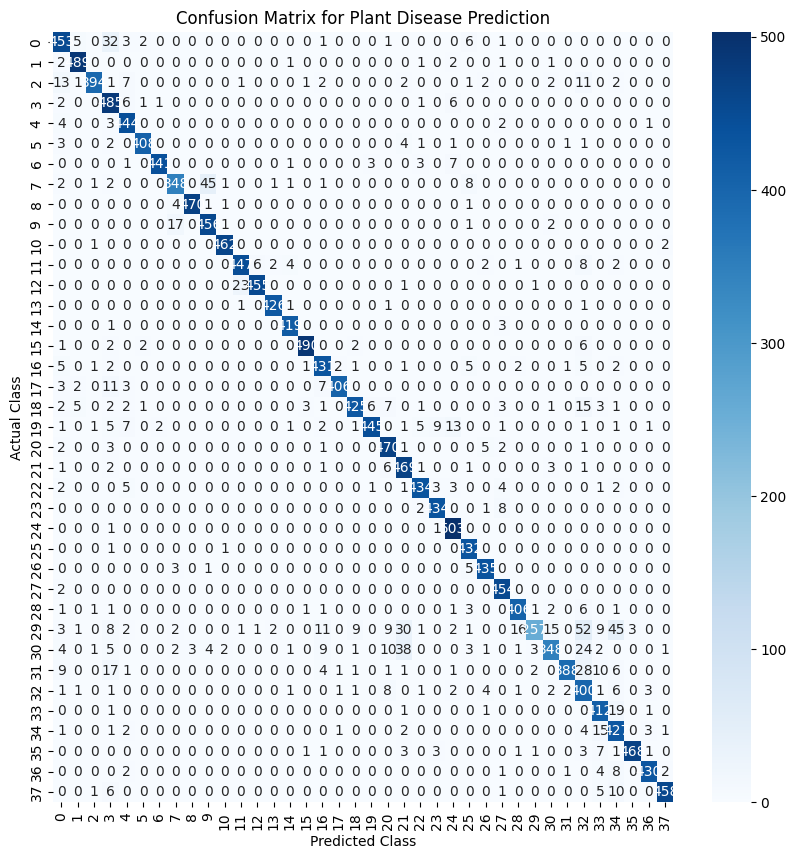

In [11]:
# Confusion Matrix
cm = confusion_matrix(Y_true, predicted_categories)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix for Plant Disease Prediction")
plt.show()

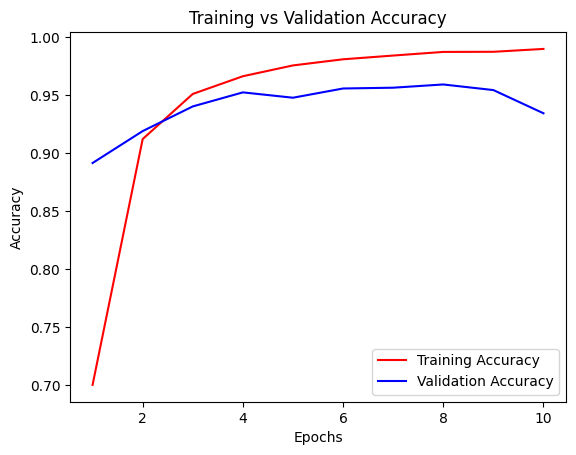

In [12]:
# Plot Accuracy
plt.plot(range(1, 11), training_history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(range(1, 11), training_history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()